In [1]:
%pip install -q transformers datasets evaluate accelerate torch scikit-learn pandas numpy matplotlib


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os, numpy as np, pandas as pd

os.makedirs("results", exist_ok=True)

df = pd.read_csv("data/sms_clean.csv")[["text","label"]]
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)

splits = np.load("data/split_idx.npz")
train_idx = splits["train_idx"].tolist()
val_idx   = splits["val_idx"].tolist()
test_idx  = splits["test_idx"].tolist()

len(train_idx), len(val_idx), len(test_idx)


(3619, 776, 776)

In [3]:
from datasets import Dataset

full_ds = Dataset.from_pandas(df, preserve_index=False)
train_ds = full_ds.select(train_idx)
val_ds   = full_ds.select(val_idx)
test_ds  = full_ds.select(test_idx)

train_ds[0]


{'text': "I think we're going to finn's now, come\n", 'label': 0}

In [5]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=96)

train_tok = train_ds.map(tokenize, batched=True)
val_tok   = val_ds.map(tokenize, batched=True)
test_tok  = test_ds.map(tokenize, batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_tok.set_format(type="torch", columns=cols)
val_tok.set_format(type="torch", columns=cols)
test_tok.set_format(type="torch", columns=cols)


Map:   0%|          | 0/3619 [00:00<?, ? examples/s]

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

Map:   0%|          | 0/776 [00:00<?, ? examples/s]

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred  # logits: (N,2), labels: (N,)
    
    # stable softmax
    logits = np.array(logits)
    exps = np.exp(logits - logits.max(axis=1, keepdims=True))
    probs = exps / exps.sum(axis=1, keepdims=True)

    spam_probs = probs[:, 1]
    preds = (spam_probs >= 0.5).astype(int)

    return {
        "accuracy": accuracy_score(labels, preds),
        "precision_spam": precision_score(labels, preds, pos_label=1, zero_division=0),
        "recall_spam": recall_score(labels, preds, pos_label=1, zero_division=0),
        "f1_spam": f1_score(labels, preds, pos_label=1, zero_division=0),
        "roc_auc": roc_auc_score(labels, spam_probs),
    }


In [7]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

args = TrainingArguments(
    output_dir="results/distilbert_out",
    eval_strategy="epoch",          # καλύτερο από evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_spam",
    greater_is_better=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,  # MPS safer
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,  # effective batch ~16
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    seed=42,
    report_to="none",
    dataloader_num_workers=0,
    dataloader_pin_memory=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    compute_metrics=compute_metrics,
)

trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Spam,Recall Spam,F1 Spam,Roc Auc
1,0.057700,0.054686,0.985825,0.948454,0.938776,0.943590,0.989089
2,0.006300,0.049445,0.990979,0.978947,0.948980,0.963731,0.986470


TrainOutput(global_step=678, training_loss=0.043887261488093035, metrics={'train_runtime': 385.9683, 'train_samples_per_second': 28.129, 'train_steps_per_second': 1.757, 'total_flos': 268792910297856.0, 'train_loss': 0.043887261488093035, 'epoch': 2.988962472406181})

In [10]:
test_metrics = trainer.evaluate(test_tok)
test_metrics


{'eval_loss': 0.029964417219161987,
 'eval_accuracy': 0.9922680412371134,
 'eval_precision_spam': 0.9893617021276596,
 'eval_recall_spam': 0.9489795918367347,
 'eval_f1_spam': 0.96875,
 'eval_roc_auc': 0.997336102582626,
 'eval_runtime': 7.5415,
 'eval_samples_per_second': 102.897,
 'eval_steps_per_second': 6.497,
 'epoch': 2.988962472406181}

In [11]:
import pandas as pd
out = {
    "accuracy": test_metrics["eval_accuracy"],
    "precision_spam": test_metrics["eval_precision_spam"],
    "recall_spam": test_metrics["eval_recall_spam"],
    "f1_spam": test_metrics["eval_f1_spam"],
    "roc_auc": test_metrics["eval_roc_auc"],
}
pd.DataFrame([out]).to_csv("results/distilbert_metrics_test.csv", index=False)
print("Saved -> results/distilbert_metrics_test.csv")


Saved -> results/distilbert_metrics_test.csv


N: 776 Positives(spam): 98


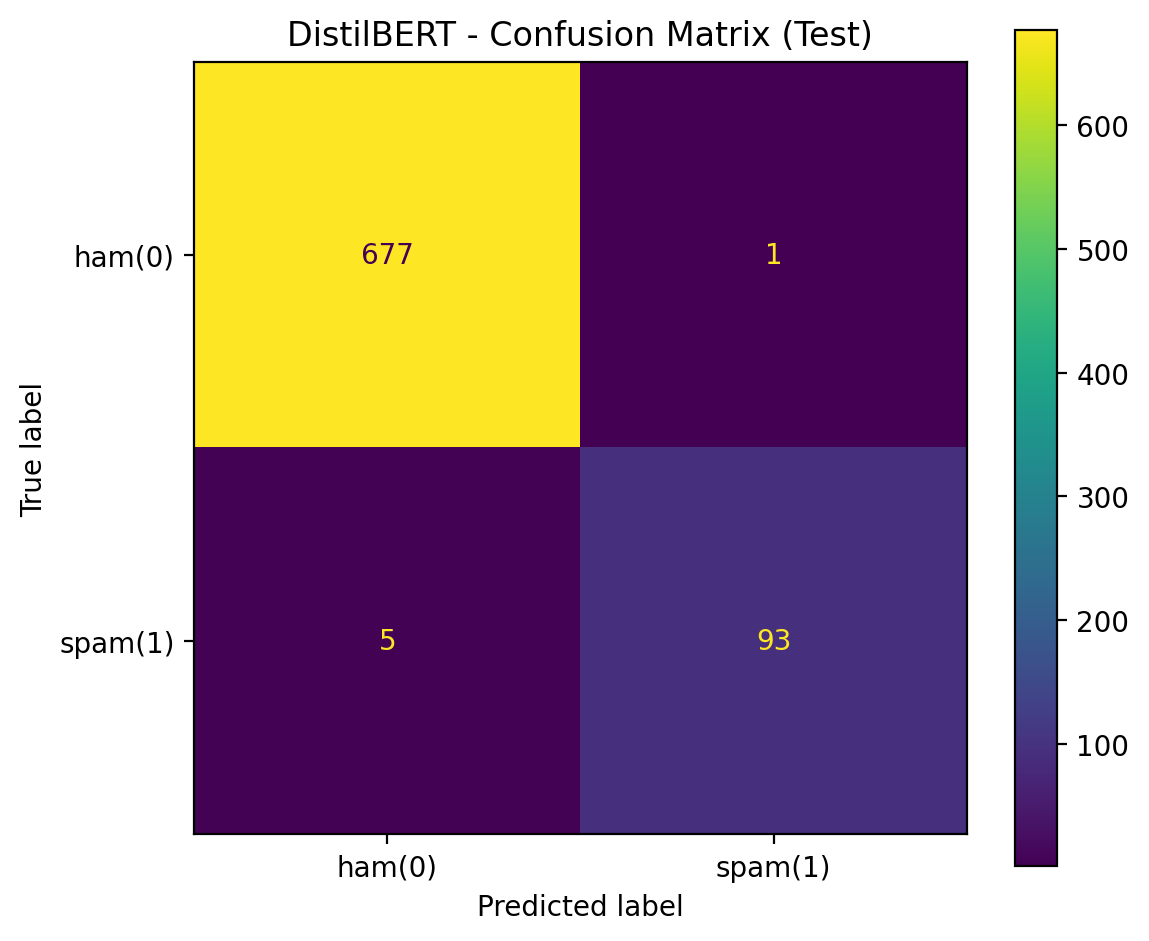

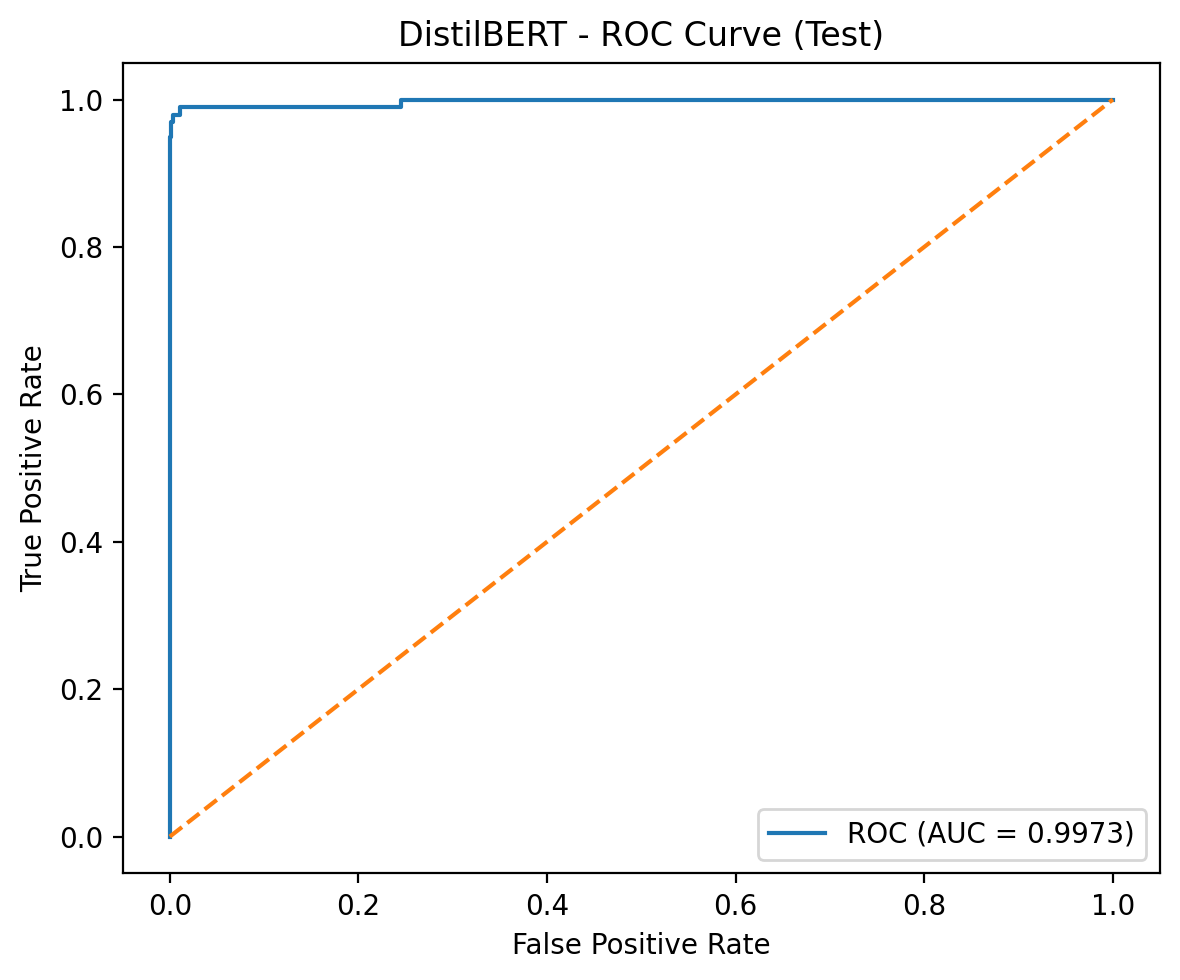

ROC-AUC (recomputed): 0.997336102582626
Saved -> results/distilbert_confusion_matrix.png
Saved -> results/distilbert_roc_curve.png
Saved -> results/distilbert_test_scores.csv


In [12]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

#  logits + labels από το test set
pred_out = trainer.predict(test_tok)   
logits = pred_out.predictions          
y_true = pred_out.label_ids            

# logits -> probabilities (softmax)
probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
spam_prob = probs[:, 1]
y_pred = (spam_prob >= 0.5).astype(int)

print("N:", len(y_true), "Positives(spam):", int(y_true.sum()))

# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["ham(0)", "spam(1)"])
fig, ax = plt.subplots(figsize=(6,5), dpi=200)
disp.plot(ax=ax, values_format="d", colorbar=True)
ax.set_title("DistilBERT - Confusion Matrix (Test)")
plt.tight_layout()
plt.savefig("results/distilbert_confusion_matrix.png")
plt.show()

# ROC curve plot + AUC
fpr, tpr, _ = roc_curve(y_true, spam_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5), dpi=200)
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.4f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DistilBERT - ROC Curve (Test)")
plt.legend()
plt.tight_layout()
plt.savefig("results/distilbert_roc_curve.png")
plt.show()

print("ROC-AUC (recomputed):", roc_auc)

pd.DataFrame({
    "y_true": y_true,
    "spam_prob": spam_prob,
    "y_pred": y_pred
}).to_csv("results/distilbert_test_scores.csv", index=False)

print("Saved -> results/distilbert_confusion_matrix.png")
print("Saved -> results/distilbert_roc_curve.png")
print("Saved -> results/distilbert_test_scores.csv")


In [13]:
from pathlib import Path
import pandas as pd
import numpy as np

Path("results").mkdir(exist_ok=True)

# add text to scores + save FP/FN
df_full = pd.read_csv("data/sms_clean.csv")[["text","label"]]
splits = np.load("data/split_idx.npz")
test_idx = splits["test_idx"]
X_test_text = df_full.iloc[test_idx]["text"].astype(str).values

scores = pd.read_csv("results/distilbert_test_scores.csv")
scores["text"] = X_test_text
scores.to_csv("results/distilbert_test_scores.csv", index=False)

y_true = scores["y_true"].values.astype(int)
y_pred = scores["y_pred"].values.astype(int)

pd.DataFrame({"text": scores.loc[(y_true==0) & (y_pred==1), "text"]}).to_csv("results/distilbert_false_positives.csv", index=False)
pd.DataFrame({"text": scores.loc[(y_true==1) & (y_pred==0), "text"]}).to_csv("results/distilbert_false_negatives.csv", index=False)

# Save best checkpoint path (so you always explain the correct model)
best_ckpt = getattr(trainer.state, "best_model_checkpoint", None)
if best_ckpt:
    Path("results/distilbert_best_checkpoint.txt").write_text(str(best_ckpt))

print("Updated -> results/distilbert_test_scores.csv (with text)")
print("Saved -> results/distilbert_false_positives.csv")
print("Saved -> results/distilbert_false_negatives.csv")
print("Saved -> results/distilbert_best_checkpoint.txt")

Updated -> results/distilbert_test_scores.csv (with text)
Saved -> results/distilbert_false_positives.csv
Saved -> results/distilbert_false_negatives.csv
Saved -> results/distilbert_best_checkpoint.txt
